In [ ]:
!pip install git+https://github.com/macrosynergy/macrosynergy@develop

In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings

warnings.simplefilter("ignore")

In [15]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - set(["IDR", "NZD"]))
cids_xg2 = list(set(cids_dux) - set(["EUR", "USD"]))

In [16]:
# Quantamental categories of interest

ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "PCREDITBN_SJA_P1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [ ]:
# load the dataset:

df = pd.read_csv('JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])

scols = ["cid", "xcat", "real_date", "value"]  # required columns
df = df[scols].copy()
display (df.tail(3))
df.info()

In [ ]:
df['ticker'] = df['cid'] + "_" + df["xcat"]
df.set_index('real_date', inplace=True)
df.sort_index(inplace=True)

print(df.head(10))

In [19]:
df_USD = df[df["cid"] == 'USD']

# make the xcat features into columns
df_USD = df_USD.pivot_table(index='real_date', columns='xcat', values='value', aggfunc='first')

df_USD = df_USD.reset_index()

# deals with missing data
df_USD = df_USD.dropna()

In [27]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(df_USD):
    pass

development_set = df_USD.iloc[train_index]
test_set_origin = df_USD.iloc[test_index]

for train_index, test_index in tss.split(development_set):
    pass

train_set = development_set.iloc[train_index]
val_set = development_set.iloc[test_index]

train_set.drop('real_date', axis=1,inplace=True)
val_set.drop('real_date', axis=1, inplace=True)
test_set = test_set_origin.drop('real_date', axis=1)

X_train = train_set.drop('DU05YXR_VT10', axis=1)
y_train = train_set['DU05YXR_VT10']

X_val = val_set.drop('DU05YXR_VT10', axis=1)
y_val = val_set['DU05YXR_VT10']

X_test = test_set.drop('DU05YXR_VT10', axis=1)
y_test = test_set['DU05YXR_VT10']

# **Lasso Regression**

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [22]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("The MSE on test set: ", mse)
print("The R2 on test set: ", r2)

The MSE on test set:  0.06417999458348775
The R2 on test set:  0.8849104445369348


In [25]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_
print(f"The best alpha value is : {best_alpha}")

The best alpha value is : 0.00195126514967403


In [26]:
# Use the best model
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_train_scaled, y_train)

y_pred_best = lasso_best.predict(X_test_scaled)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"The MSE on test set is: {mse_best}")
print(f"The R2 on test set is: {r2_best}")

The MSE on test set is: 0.0556303447722622
The R2 on test set is: 0.9002419415637667


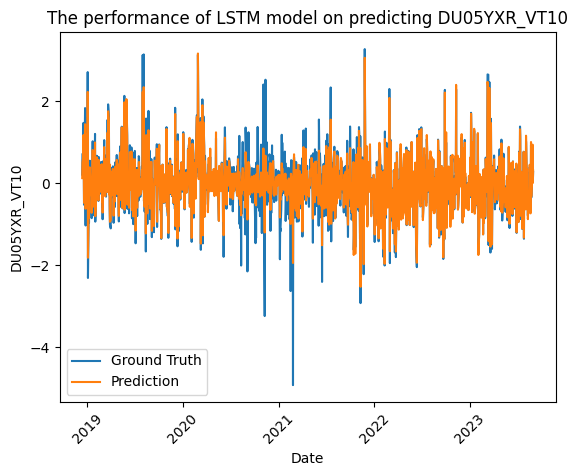

In [31]:
plt.title("The performance of LSTM model on predicting DU05YXR_VT10")
plt.plot(test_set_origin['real_date'], y_test)
plt.plot(test_set_origin['real_date'], y_pred_best)
plt.xticks(rotation=45)
plt.legend(['Ground Truth', 'Prediction'])
plt.xlabel('Date')
plt.ylabel('DU05YXR_VT10')
plt.show()